# MODELO: NEURAL-PROPHET

In [ ]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import glob
import warnings
import logging

# Desactiva los warnings y ajusta el logging
warnings.filterwarnings("ignore")
logging.getLogger("NP").setLevel(logging.ERROR)

#### 1. Cargamos los datos de entrenamiento

In [2]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('predictions_dia_avg/predictions_2.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

df = df.rename(columns={'day': 'ds', 'avg_all_users': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df = df.sort_values('ds')

df.head()

datetime64[ns]


,ds,y
0,2019-01-01,0.023793
1,2019-01-02,0.020000
2,2019-01-03,0.032143
3,2019-01-04,0.011852
4,2019-01-05,0.010000


Repartimos los datos entre train y test. Se han eliminado los datos anteriores a 2020 ya que meten mucho ruido en el modelo. Por otra parte, se valora el quitar también los datos de 2024 ya que no es un año completo, las medias salen más altas (no esta el año completo) y hay más contadores nuevos.

In [ ]:
df = df[df["ds"] >= "2020-01-01 00:00:00"] # Quitamos datos anteriores a 2020
# df = df[df["ds"] < "2024-01-01 00:00:00"] # Quitamos datos de 2024

In [ ]:
# Seccionamos datos en train y test

df_data_train = df[df["ds"] < "2023-12-01 00:00:00"]
df_data_test = df[df["ds"] >= "2023-12-01 00:00:00"] 

#### 2. Crear y entrenar el modelo NeuralProphet

In [ ]:
model_global = NeuralProphet(
    # n_lags=90,             # Captura dependencias de 30 días anteriores
    n_forecasts=30,        # Predicción de 30 días hacia adelante
    yearly_seasonality=True,  # Estacionalidad anual
    weekly_seasonality=True,  # Estacionalidad semanal
    daily_seasonality=True,   # Desactivar estacionalidad diaria si no es relevante
    ar_layers=[64, 64, 64, 64],
    learning_rate=0.09,
    growth="off",
    epochs=100
)

model_global.add_country_holidays(country_name="ES")

# Entrenar el modelo
history = model_global.fit(df_data_train, freq="D")

# 2. Realizar predicciones en el conjunto de prueba
future = model_global.make_future_dataframe(df_data_train, periods=len(df_data_test), n_historic_predictions=True)
forecast = model_global.predict(future)

# 3. Extraer predicciones y valores reales para calcular métricas
results_df = forecast[["ds", "yhat1"]].merge(df, on="ds", how="left")
results_df.rename(columns={"yhat1": "y_pred", "y": "y_real"}, inplace=True)


Epoch 1:   1%|          | 1/100 [00:00<00:00, 1240.92it/s]

Training: |          | 0/? [00:13<?, ?it/s, v_num=5716, train_loss=0.0284, reg_loss=0.000, MAE=0.00199, RMSE=0.00246, Loss=0.0283, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 540.85it/s]


In [7]:
# Revisar la evolución de la pérdida para identificar si el modelo deja de mejorar
history.head()

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.817011,0.0,0.019207,0.022971,0.813656,0.0,0
1,0.207935,0.0,0.006330,0.007639,0.207043,0.0,1
2,0.041303,0.0,0.002355,0.002947,0.041332,0.0,2
3,0.032326,0.0,0.002127,0.002625,0.032295,0.0,3
4,0.031316,0.0,0.002078,0.002567,0.031312,0.0,4


In [8]:
results_df

,ds,y_pred,y_real
0,2020-01-01,0.045209,0.036172
1,2020-01-02,0.044764,0.039014
2,2020-01-03,0.044751,0.040680
3,2020-01-04,0.044110,0.041579
4,2020-01-05,0.043608,0.040861
...,...,...,...
1456,2023-12-27,0.045866,0.047918
1457,2023-12-28,0.045778,0.046999
1458,2023-12-29,0.045756,0.046942
1459,2023-12-30,0.044773,0.047463


##### 2.1 Evaluación del modelo

In [ ]:
mae = mean_absolute_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna())
rmse = mean_squared_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna(), squared=False)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(results_df["y_real"].dropna(), results_df["y_pred"].dropna())

# 4. Imprimir métricas
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.0020
RMSE: 0.0025
MAPE: 4.30%


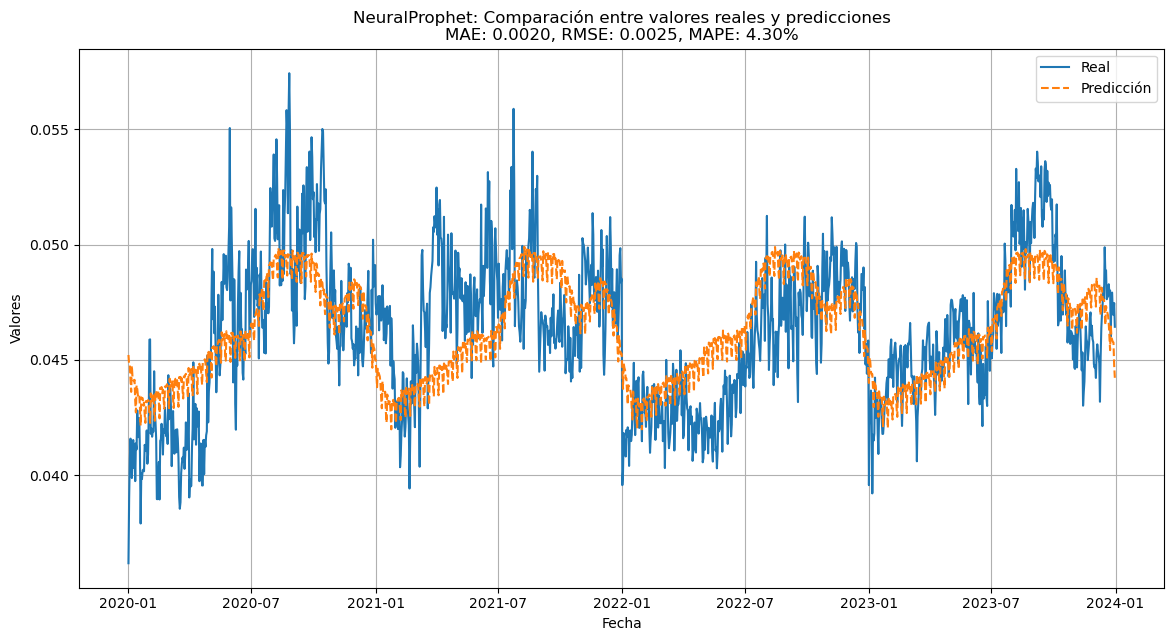

In [ ]:
# Graficar resultados
plt.figure(figsize=(14, 7))
plt.plot(results_df["ds"], results_df["y_real"], label="Real")
plt.plot(results_df["ds"], results_df["y_pred"], label="Predicción", linestyle="--")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"NeuralProphet: Comparación entre valores reales y predicciones\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.legend()
plt.grid()
plt.show()

# # Guardar resultados en CSV
# results_df.to_csv("resultados_neuralprophet.csv", index=False)

#### 3. Cargamos datos usuarios individuales

In [11]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('data_testing/cluster_2_filter_users.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df = df.rename(columns={'day': 'ds', 'avg_value': 'y', 'serial_number': 'user_id'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df_users = df.sort_values('ds')
df_users.tail()

datetime64[ns]


,ds,user_id,y
69288,2023-12-31,I20EB021287,0.085042
69287,2023-12-31,I20EA211006,0.046167
69286,2023-12-31,I20EA210877,0.075125
69283,2023-12-31,I20EA210546,0.000000
69285,2023-12-31,I20EA210875,0.068708


Filtramos por el usuario (serial number) del que queramos predecir su consumo futuro:

In [12]:
# Filtrar por serial_number de interés
serial_to_predict = "J18YA009998"  # Serial que quieres predecir
df_filtered = df_users[df_users['user_id'] == serial_to_predict]
df_filtered = df_filtered.sort_values('ds')
df_filtered.head()

,ds,user_id,y
108406,2022-01-01,J18YA009998,0.022333
108504,2022-01-02,J18YA009998,0.027833
108603,2022-01-03,J18YA009998,0.026417
108702,2022-01-04,J18YA009998,0.024542
108801,2022-01-05,J18YA009998,0.025043


In [13]:
# Para este caso los datos de entrenamiento terminan en "2022-12-31"
data_user = df_filtered[['ds','y']]
                        
future = model_global.make_future_dataframe(data_user, periods=31, n_historic_predictions=True)  # 31 días para enero de 2023
forecast_user = model_global.predict(future)

# # Filtrar las predicciones para enero de 2023
# forecast_jan_2023 = forecast_user[forecast_user['ds'] >= '2023-01-01']

# # Ver las predicciones
# forecast_jan_2023[['ds', 'yhat1']].head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 486.30it/s]


In [14]:
# Filtrar las fechas de prueba
test_data = data_user.copy()  # data_user contiene los valores reales
test_data['ds'] = pd.to_datetime(test_data['ds'])

# Combinar valores reales y predichos en un solo DataFrame
results = pd.merge(test_data, forecast_user[['ds', 'yhat1']], on='ds', how='inner')

# Renombrar columnas para mayor claridad
results = results.rename(columns={'y': 'y_real', 'yhat1': 'y_pred'})

# Calcular el error absoluto y los porcentajes de error
results['error'] = results['y_real'] - results['y_pred']
results['abs_error'] = results['error'].abs()
results['abs_pct_error'] = (results['abs_error'] / results['y_real']) * 100  # Error porcentual

# Calcular las métricas
# MAE y RMSE con scikit-learn
y_real = results['y_real']
y_pred = results['y_pred']

mae = mean_absolute_error(y_real, y_pred)
rmse = mean_squared_error(y_real, y_pred, squared=False)  # RMSE
# MAPE (ya calculado previamente)
mape = results['abs_pct_error'].mean()

# 3. Mostrar resultados
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 0.013271110903970384
RMSE: 0.01677123355132039
MAPE: 33.37191737024134%


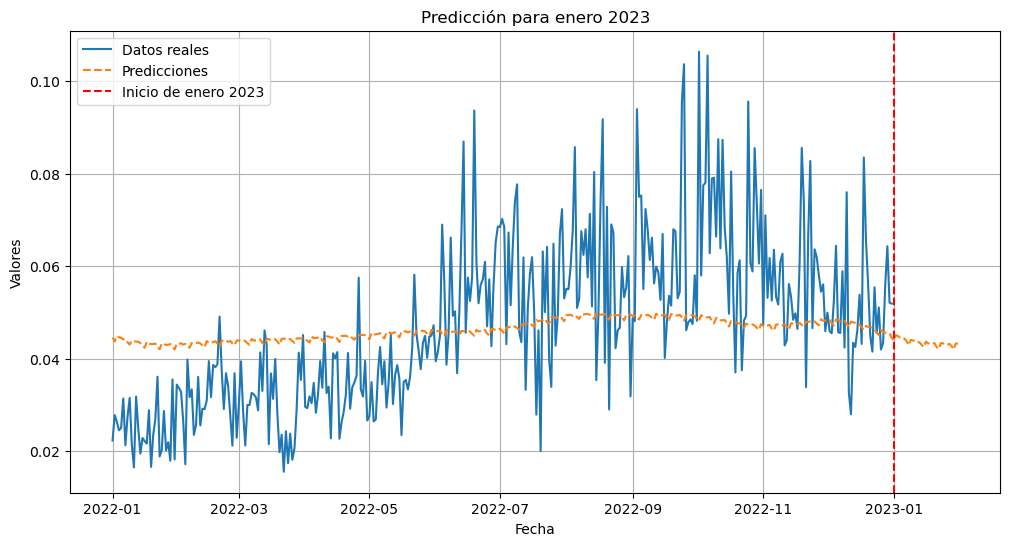

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que las fechas están en formato datetime
forecast_user['ds'] = pd.to_datetime(forecast_user['ds'])
data_user['ds'] = pd.to_datetime(data_user['ds'])

# Define la fecha para la línea vertical
vertical_line_date = pd.to_datetime('2023-01-01')

# Graficar los datos reales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(data_user['ds'], data_user['y'], label='Datos reales')  # Datos históricos
plt.plot(forecast_user['ds'], forecast_user['yhat1'], label='Predicciones', linestyle='dashed')  # Predicciones
plt.axvline(x=vertical_line_date, color='red', linestyle='--', label='Inicio de enero 2023')  # Línea separadora
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Predicción para enero 2023')
plt.legend()
plt.grid()
plt.show()


### APÉNDICE - EXPERIMENTOS VARIOS

##### OPCIÓN MODELO HÍBRIDO

1. Regresor Lineal:

In [25]:
from sklearn.linear_model import LinearRegression

# Lista de usuarios a ajustar
user_ids = df_users['user_id'].unique()

# Ajuste específico por usuario
user_adjusted_predictions_lr = {}

for user_id in user_ids:
    try:
        # Filtrar los datos del usuario
        df_user = df_users[df_users['user_id'] == user_id]

        # Eliminar la columna 'user_id' antes de hacer la predicción
        df_user_for_pred = df_user[['ds', 'y']].copy()  # Solo mantener 'ds' y 'y'
        
        # Asegurarse de que las fechas están en formato datetime
        df_user_for_pred['ds'] = pd.to_datetime(df_user_for_pred['ds'])
        
        # Realizar predicciones con el modelo global
        future_user = model_global.make_future_dataframe(df_user_for_pred, periods=30)
        forecast_global_user = model_global.predict(future_user)

        # Limitar las predicciones a las fechas existentes en df_user
        forecast_global_user = forecast_global_user[forecast_global_user['ds'].isin(df_user_for_pred['ds'])]

        # Unir las predicciones globales con los datos reales del usuario por la columna 'ds'
        df_user_predictions = df_user[['ds', 'y']].copy()
        df_user_predictions = df_user_predictions.merge(forecast_global_user[['ds', 'yhat1']], on='ds', how='left')

        # # Verificar NaN en las predicciones globales
        # print("¿Hay NaN en las predicciones globales?")
        # print(df_user_predictions[['yhat1', 'y']].isna().sum())
        
        # Si hay NaN en las predicciones, reemplazarlas o eliminar las filas
        df_user_predictions['yhat_global'] = df_user_predictions['yhat1'].fillna(0)  # O utilizar otro valor por defecto

        # Verificar si después de este paso hay datos disponibles
        if df_user_predictions.empty:
            print(f"No hay datos disponibles para el usuario {user_id}, pasando al siguiente usuario.")
            continue

        # Ajustar las predicciones globales con un modelo de regresión lineal
        X = df_user_predictions['yhat_global'].values.reshape(-1, 1)
        y = df_user_predictions['y'].values
        
        # Entrenar el modelo de regresión lineal
        model_lr = LinearRegression()
        model_lr.fit(X, y)
        
        # Ajustar las predicciones
        yhat_adjusted = model_lr.predict(X)
        
        # Almacenar las predicciones ajustadas en el diccionario
        user_adjusted_predictions_lr[user_id] = yhat_adjusted

    except Exception as e:
        # En caso de que ocurra algún error (por ejemplo, NaN en todas las filas o cualquier otro error)
        print(f"Error procesando al usuario {user_id}: {e}")
        continue

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 617.35it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


In [26]:
print(len(user_adjusted_predictions_lr))
print(len(user_ids))

269
269


2. Segundo modelo con NeuralProphet de nuevo:

In [ ]:
from neuralprophet import NeuralProphet
import pandas as pd

# Lista de usuarios a ajustar
user_ids = df_users['user_id'].unique()

# Diccionario para almacenar las predicciones ajustadas de cada usuario
user_adjusted_predictions = {}

for user_id in user_ids:
    try:
        # Filtrar los datos del usuario
        df_user = df_users[df_users['user_id'] == user_id]

        # Verificar si el usuario tiene datos
        if df_user.empty:
            print(f"El usuario {user_id} no tiene datos. Saltando al siguiente usuario.")
            continue

        # Eliminar la columna 'user_id' antes de hacer la predicción
        df_user_for_pred = df_user[['ds', 'y']].copy()  # Solo mantener 'ds' y 'y'
        
        # Asegurarse de que las fechas están en formato datetime
        df_user_for_pred['ds'] = pd.to_datetime(df_user_for_pred['ds'])

        # 1. Realizar predicciones con el modelo global de NeuralProphet
        future_user = model_global.make_future_dataframe(df_user_for_pred, periods=30, n_historic_predictions=True)
        
        forecast_global_user = model_global.predict(future_user)

        # Imprimir las primeras filas de las predicciones globales
        print(f"Predicciones globales para el usuario {user_id}:")
        print(forecast_global_user.head())

        # Limitar las predicciones a las fechas existentes en df_user
        forecast_global_user = forecast_global_user[forecast_global_user['ds'].isin(df_user_for_pred['ds'])]

        # Verificar si las predicciones globales tienen datos
        if forecast_global_user.empty:
            print(f"No hay predicciones globales disponibles para el usuario {user_id}. Pasando al siguiente usuario.")
            continue

        # 2. Crear un dataframe con las predicciones globales y los datos reales del usuario
        df_user_predictions = df_user[['ds', 'y']].copy()
        df_user_predictions = df_user_predictions.merge(forecast_global_user[['ds', 'yhat1']], on='ds', how='left')

        # Verificar la cantidad de NaNs en las predicciones globales
        print(f"Cantidad de NaNs en las predicciones globales para el usuario {user_id}:")
        print(df_user_predictions[['yhat1', 'y']].isna().sum())

        # Reemplazar NaN en las predicciones globales si es necesario
        df_user_predictions['yhat_global'] = df_user_predictions['yhat1'].fillna(0)  # Puedes cambiar 0 por otro valor

        # Verificar si después de este paso hay datos disponibles
        if df_user_predictions.empty or df_user_predictions['yhat_global'].isna().sum() == len(df_user_predictions):
            print(f"No hay datos válidos para el usuario {user_id}, pasando al siguiente usuario.")
            continue

        # 3. Ajustar las predicciones globales utilizando NeuralProphet
        df_adjustment = df_user_predictions[['ds', 'yhat_global']].copy()
        df_adjustment.rename(columns={'yhat_global': 'y'}, inplace=True)  # Renombrar la columna de predicción global a 'y'

        model_adjustment = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model_adjustment.fit(df_adjustment)
        
        # Realizar las predicciones ajustadas
        future_adjustment = model_adjustment.make_future_dataframe(df_adjustment, periods=30)
        forecast_adjusted_user = model_adjustment.predict(future_adjustment)
        
        # 4. Almacenar las predicciones ajustadas
        df_user_predictions['yhat_adjusted'] = forecast_adjusted_user['yhat1']  # Predicciones ajustadas
        df_user_predictions['user_id'] = user_id
        
        # Almacenar las predicciones ajustadas para este usuario
        user_adjusted_predictions[user_id] = df_user_predictions

    except Exception as e:
        # En caso de que ocurra algún error (por ejemplo, NaN en todas las filas o cualquier otro error)
        print(f"Error procesando al usuario {user_id}: {e}")

# Ejemplo de cómo acceder a las predicciones ajustadas de un usuario específico
user_id_example = 'FCC23D008DFD'
if user_id_example in user_adjusted_predictions:
    adjusted_predictions_user = user_adjusted_predictions[user_id_example]
    print(f"Predicciones ajustadas para el usuario {user_id_example}:")
    print(adjusted_predictions_user)
else:
    print(f"No hay predicciones ajustadas disponibles para el usuario {user_id_example}.")


In [36]:
print(len(user_adjusted_predictions))
print(len(user_ids))

269
269


In [33]:
# Ejemplo de cómo acceder a las predicciones ajustadas de un usuario específico
user_id_example = 'J18YA009998'
adjusted_predictions_user = user_adjusted_predictions_lr[user_id_example]

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_user_example = df_users[df_users['user_id'] == user_id_example]

y_real = df_user_example['y'].values  # Valores reales
y_pred_adjusted = adjusted_predictions_user  # Predicciones ajustadas

# Calcular el error
mae = mean_absolute_error(y_real, y_pred_adjusted)
rmse = mean_squared_error(y_real, y_pred_adjusted, squared=False)  # RMSE
mape = np.mean(np.abs((y_real - y_pred_adjusted) / y_real)) * 100  # MAPE

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 0.014606758547943677
RMSE: 0.018064936955215414
MAPE: 37.71660639891596
